# Import datasets

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits import mplot3d
from collections import OrderedDict
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
imdb_title_ratings = pd.read_csv('data/imdb.title.ratings.csv')
imdb_title_basics = pd.read_csv('data/imdb.title.basics.csv')
tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

# Data Merge & Cleaning

In [4]:
imdb_joined = pd.merge(imdb_title_basics, imdb_title_ratings, on='tconst', how='left')

imdb_joined['title'] = imdb_joined['primary_title']

imdb_joined['year'] = imdb_joined['start_year']

tn_movie_budgets['title'] = tn_movie_budgets['movie']

tn_movie_budgets['year'] = tn_movie_budgets['release_date'].map(lambda x:x[-4:]).astype(int)

df = pd.merge(tn_movie_budgets, imdb_joined, on =["title", "year"], how ='left')

df['production_budget'] = df['production_budget'].map(lambda x:float(x.replace("$", "").replace(",", "")))
df['domestic_gross'] = df['domestic_gross'].map(lambda x:float(x.replace("$", "").replace(",", "")))
df['worldwide_gross'] = df['worldwide_gross'].map(lambda x:float(x.replace("$", "").replace(",", "")))

df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year_month'] = df['release_date'].dt.to_period("M")

df = df.drop_duplicates(['title'])

df.drop(['id', 'movie', 'tconst', 'primary_title', 'original_title', 'start_year'], axis = 1, inplace = True)

#df.info()

#df.head()

df.isna().sum()

df = df[~df['runtime_minutes'].isna()]
df = df[~df['genres'].isna()]
df = df[~df['averagerating'].isna()]
df = df[~df['numvotes'].isna()]

df.isna().sum()

df.drop(df.index[df['domestic_gross'] == 0], inplace = True)
df.drop(df.index[df['worldwide_gross'] == 0], inplace = True)

#df.describe()

df['domestic_profit'] = df['domestic_gross'] - df['production_budget']
df['worldwide_profit'] = df['worldwide_gross'] - df['production_budget']

df = df[['title', 'genres', 'runtime_minutes',\
        'year', 'release_year_month', 'release_date', 'averagerating',\
        'numvotes', 'production_budget', 'domestic_gross', 'domestic_profit',\
         'worldwide_gross', 'worldwide_profit']]

df.describe()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 1 to 5806
Data columns (total 13 columns):
title                 1294 non-null object
genres                1294 non-null object
runtime_minutes       1294 non-null float64
year                  1294 non-null int64
release_year_month    1294 non-null period[M]
release_date          1294 non-null datetime64[ns]
averagerating         1294 non-null float64
numvotes              1294 non-null float64
production_budget     1294 non-null float64
domestic_gross        1294 non-null float64
domestic_profit       1294 non-null float64
worldwide_gross       1294 non-null float64
worldwide_profit      1294 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(2), period[M](1)
memory usage: 141.5+ KB


### Dataset cleaned!

# Data Exploration

In [5]:
df.sort_values(['worldwide_profit'],ascending=False).head(3)

,title,genres,runtime_minutes,year,release_year_month,release_date,averagerating,numvotes,production_budget,domestic_gross,domestic_profit,worldwide_gross,worldwide_profit
6,Avengers: Infinity War,"Action,Adventure,Sci-Fi",149.0,2018,2018-04,2018-04-27,8.5,670926.0,300000000.0,678815482.0,378815482.0,2.048134e+09,1.748134e+09
33,Jurassic World,"Action,Adventure,Sci-Fi",124.0,2015,2015-06,2015-06-12,7.0,539338.0,215000000.0,652270625.0,437270625.0,1.648855e+09,1.433855e+09
67,Furious 7,"Action,Crime,Thriller",137.0,2015,2015-04,2015-04-03,7.2,335074.0,190000000.0,353007020.0,163007020.0,1.518723e+09,1.328723e+09


## 1-Profit: Domestic vs Worldwide

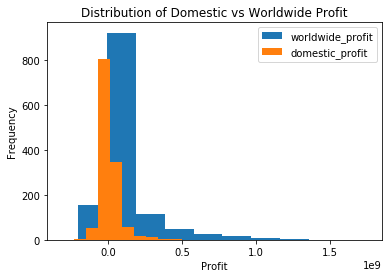

In [6]:
df['worldwide_profit'].plot(kind='hist') 
df['domestic_profit'].plot(kind='hist') 

plt.title('Distribution of Domestic vs Worldwide Profit')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend(loc='best')  # legend text comes from the plot's label parameter.
plt.show()



## 2-Genre 

### 1-1-Combined Genres 

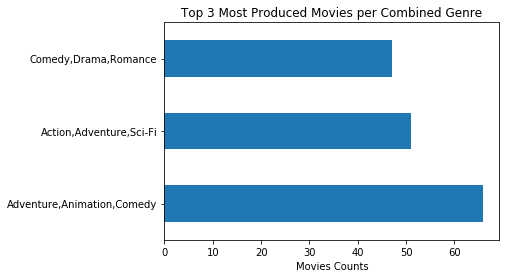

In [7]:
#Sort dataframe by genre
pd.value_counts(df['genres']).head(3).plot(kind='barh')   
plt.title('Top 3 Most Produced Movies per Combined Genre')
plt.xlabel('Movies Counts')
df['Percentage_Profit_Worldwide']=df['worldwide_profit']/df['production_budget']

**Adventure-Animation-Comedy** is the combination of movies that is the most produced

In [8]:
# Sorted dataframe by genres
df = df.sort_values('genres',ascending=True)

### 1-2-Unique Genre

In [9]:
# Get the unique genre
Unique_Genre =[]
for x in df.genres.str.split(",") :
    Unique_Genre.extend(x)

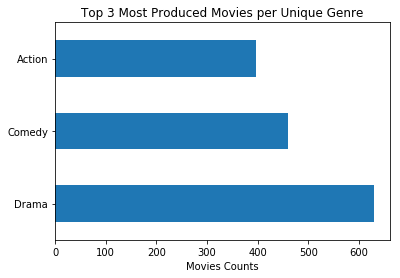

In [10]:
pd.value_counts(Unique_Genre).head(3).plot(kind='barh') 
plt.title('Top 3 Most Produced Movies per Unique Genre')
plt.xlabel('Movies Counts')
plt.show()

**Drama**, **comedy**, and **action** movies are the most produced genres

# Data Analysis 

## 1-Counts, Genre and Profit

Create a subset per genre 

In [11]:
genres_=list(((pd.value_counts(df['genres'])).to_dict()).keys())
counts_=list(((pd.value_counts(df['genres'])).to_dict()).values())
df1 = pd.DataFrame()
df1['genres_']=genres_
df1['counts_']=counts_
df1=df1.sort_values(by=['genres_'])
df_genre=(df.groupby(['genres']).mean())
# Adding the columns "counts" and "genres"
df_genre['counts'] = list(df1['counts_'])
df_genre['genres'] = list(df1['genres_'])

There are **209** genres of movies in our dataset and Create a subset that has at least 10 counts per genre 

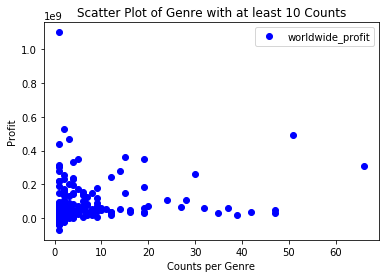

In [12]:
plt.plot(df_genre['counts'], df_genre['worldwide_profit'], 'bo')
plt.title('Scatter Plot of Genre with at least 10 Counts')
plt.xlabel('Counts per Genre')
plt.ylabel('Profit')
plt.legend(loc='best')
plt.show()

In [13]:
df_subset=pd.DataFrame()
df_subset["genres"]=df_genre["genres"]
df_subset["counts"]=df_genre["counts"]
df_subset["worldwide_profit"]=df_genre['worldwide_profit']
df_subset["Perc"]=df_genre['worldwide_profit']
df_subset["numvotes"]=df_genre["numvotes"]
df_subset["averagerating"]=df_genre["averagerating"]
df_subset["Percentage_Profit_Worldwide"]=df_genre["Percentage_Profit_Worldwide"]
df_subset= df_subset[(df_subset['counts']>=10)]

There are **33** genres of movies in our dataset.

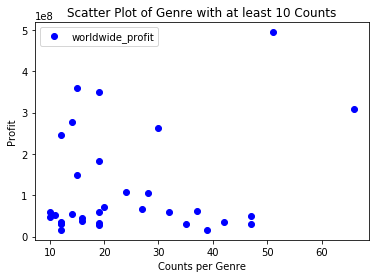

In [14]:
plt.plot(df_subset['counts'], df_subset['worldwide_profit'], 'bo')
plt.title('Scatter Plot of Genre with at least 10 Counts')
plt.xlabel('Counts per Genre')
plt.ylabel('Profit')
plt.legend(loc='best')
plt.show()

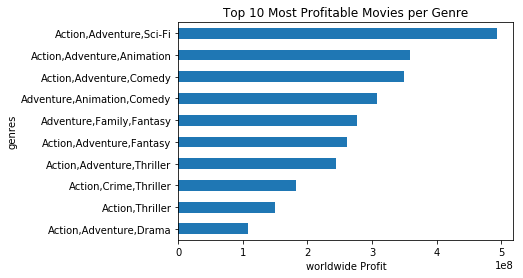

In [15]:
df_subset2 = df_subset.sort_values('worldwide_profit',ascending=True)
df_subset2['worldwide_profit'].tail(10).plot(kind='barh')
plt.xlabel('worldwide Profit')
plt.title('Top 10 Most Profitable Movies per Genre')
plt.show()

## 2-Counts, Genre and Percentage Profit

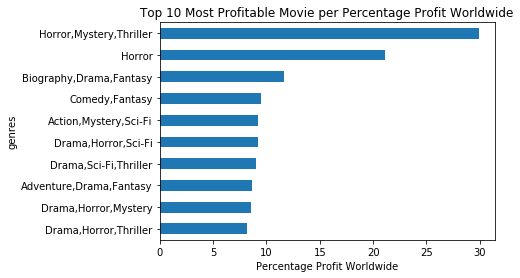

In [16]:
plt.figure() 
df_genre = df_genre.sort_values('Percentage_Profit_Worldwide',ascending=True)
df_genre['Percentage_Profit_Worldwide'].tail(10).plot(kind='barh')
plt.xlabel('Percentage Profit Worldwide')
plt.title('Top 10 Most Profitable Movie per Percentage Profit Worldwide')
plt.show()